# 5. Support Vector Machines

支持向量机（SVM）是一种功能强大且功能多样的机器学习模型，**能够执行线性或非线性分类，回归，甚至异常值检测**。 它是机器学习中最受欢迎的模型之一，任何对机器学习感兴趣的人都应该在他们的工具箱中使用它。**SVM特别适用于复杂但小型或中型数据集的分类**。本章将解释SVM的核心概念，如何使用它们以及如何使用它们工作。

关于支持向量机更多的理解可以参考：
* 李航的统计学习方法
* [支持向量机通俗导论（理解SVM的三层境界）](https://blog.csdn.net/v_july_v/article/details/7624837)

### Setup

In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
# 让笔记全程输入稳定
np.random.seed(42)

# To plot pretty figures
# 导入绘图工具
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# 设定图片保存路径，这里写了一个函数，后面直接调用即可
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "05_Support Vector Machines"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# 忽略无用警告
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 5.1 Linear SVM Classification

要解释SVM背后的基本思想最好使用一些图片。图5-1显示了第4章末尾介绍的鸢尾花数据集的一部分。这两个类可以很容易地用直线分开（它们是**线性可分**的）。
* 左图显示了三种可能的线性分类器的**决策边界**。**决策边界由虚线表示的模型非常糟糕**，甚至没有正确地分类。
* 另外两个模型在这个训练集上完美地工作，但他们的决策边界与实例非常接近，这些模型可能在新实例上表现不佳。
* 相反，右图中的**实线表示的SVM分类器决策边界**;这一行不仅将两个类分开，而且**尽可能远离最近的训练实例**。

您可以将SVM分类器视为适合类之间最宽的**间隔**（由平行虚线表示）。这称为最大间隔分类。
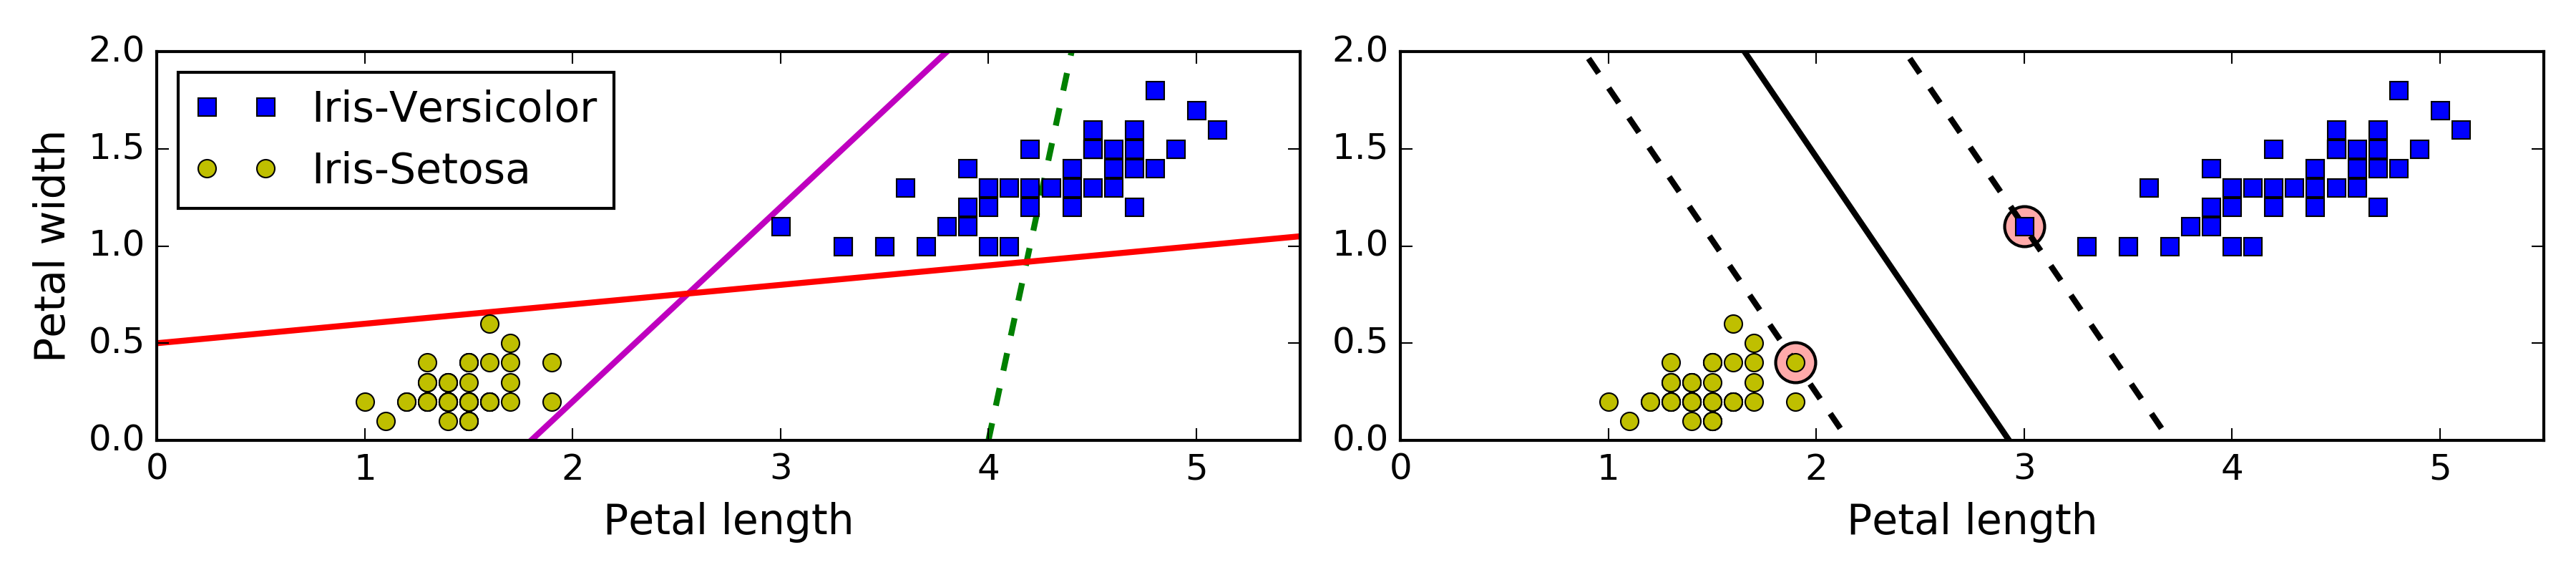

下面的代码用来生成图5-1：

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Saving figure large_margin_classification_plot


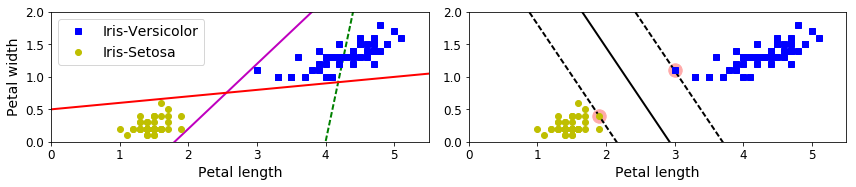

In [3]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

请注意，在间隔之外添加更多训练实例不会影响决策边界：**它完全由（位于）间隔之上的实例确定（或“支持”）**。 这些实例称为**支持向量**（上图中被圈出来
出来的点）。

**SVM对特征尺度很敏感**，如图5-2所示：在左图中，垂直尺度远大于水平尺度，因此最宽的间隔接近水平。在特征缩放（例如，使用Scikit-Learn的StandardScaler）之后，决策边界看起来好得多（在右图上）。
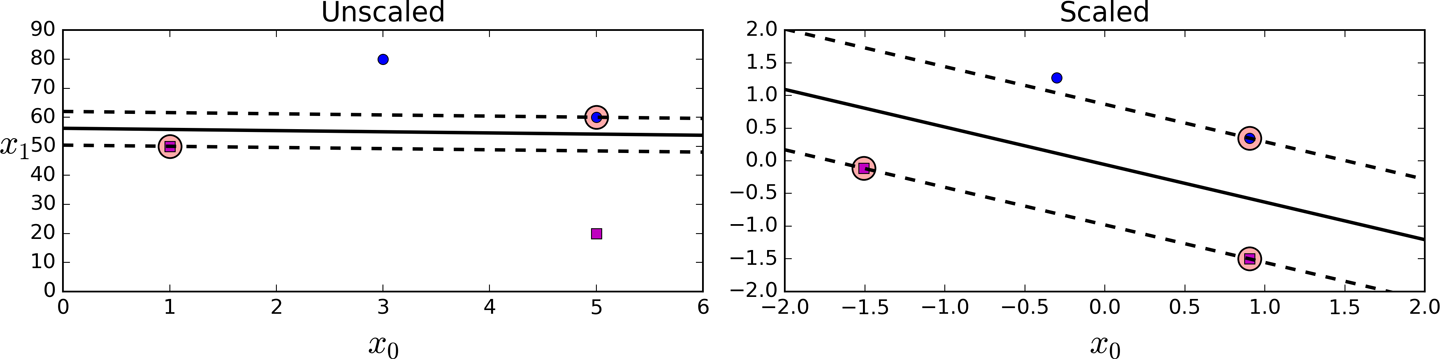

#### 5.1.1 Soft Margin Classification

如果我们严格强制规定所有实例都不在间隔内并且正确的处在间隔的两侧，这称为**硬间隔最大化分类**。硬间隔最大化分类有两个主要问题：

* 首先，它只有在数据是**线性可分**的情况下才有效，
* 其次它**对异常值非常敏感**。

图5-3显示了鸢尾花数据集，只有一个额外的异常值：在左边，不可能找到一个硬间隔，在右边，决策边界最终与我们在图5-1中看到的没有异常值的情况截然不同，并且它可能也不会泛化的很好。
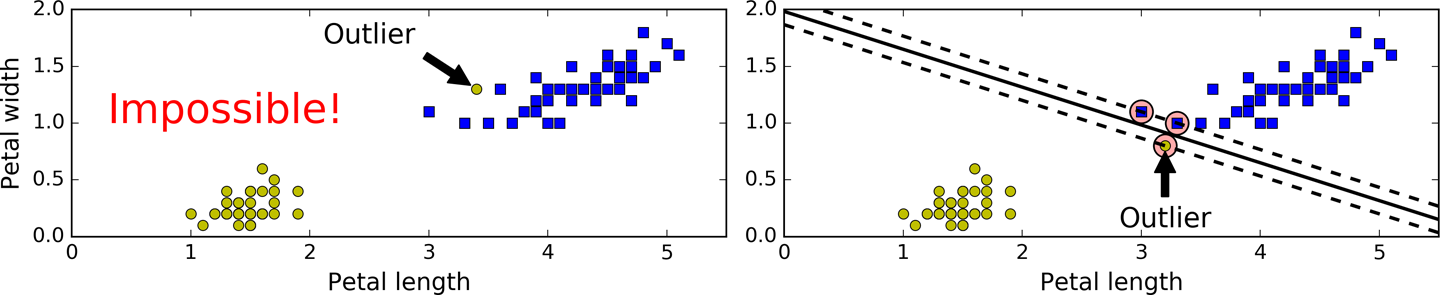

为了避免这些问题，最好使用更灵活的模型。目标是在保持街道尽可能大和限制误分类（即实例在街道中间甚至在错误一侧的情况）之间找到一个很好的**平衡点**
。 这称为**软间隔分类**。

在Scikit-Learn的SVM类中，我们可以使用**C超参数**控制此平衡：**较小的C值会导致更宽的间隔但更多的误分类**。图5-4显示了两个软间隔SVM分类器在**非线性可分数据集**上的决策边界和间隔：
* 在左侧，使用**较高的C值**，分类器会减少误分类，但最终会有较小间隔。
* 在右侧，使用**较低的C值**，间隔要大得多，但很多实例最终会出现在间隔之内。

然而，似乎第二个分类器可能会更好地推广：事实上即使在这个训练集上它也会减少预测误差，因为大多数误分类实际上都在决策边界的正确一侧。
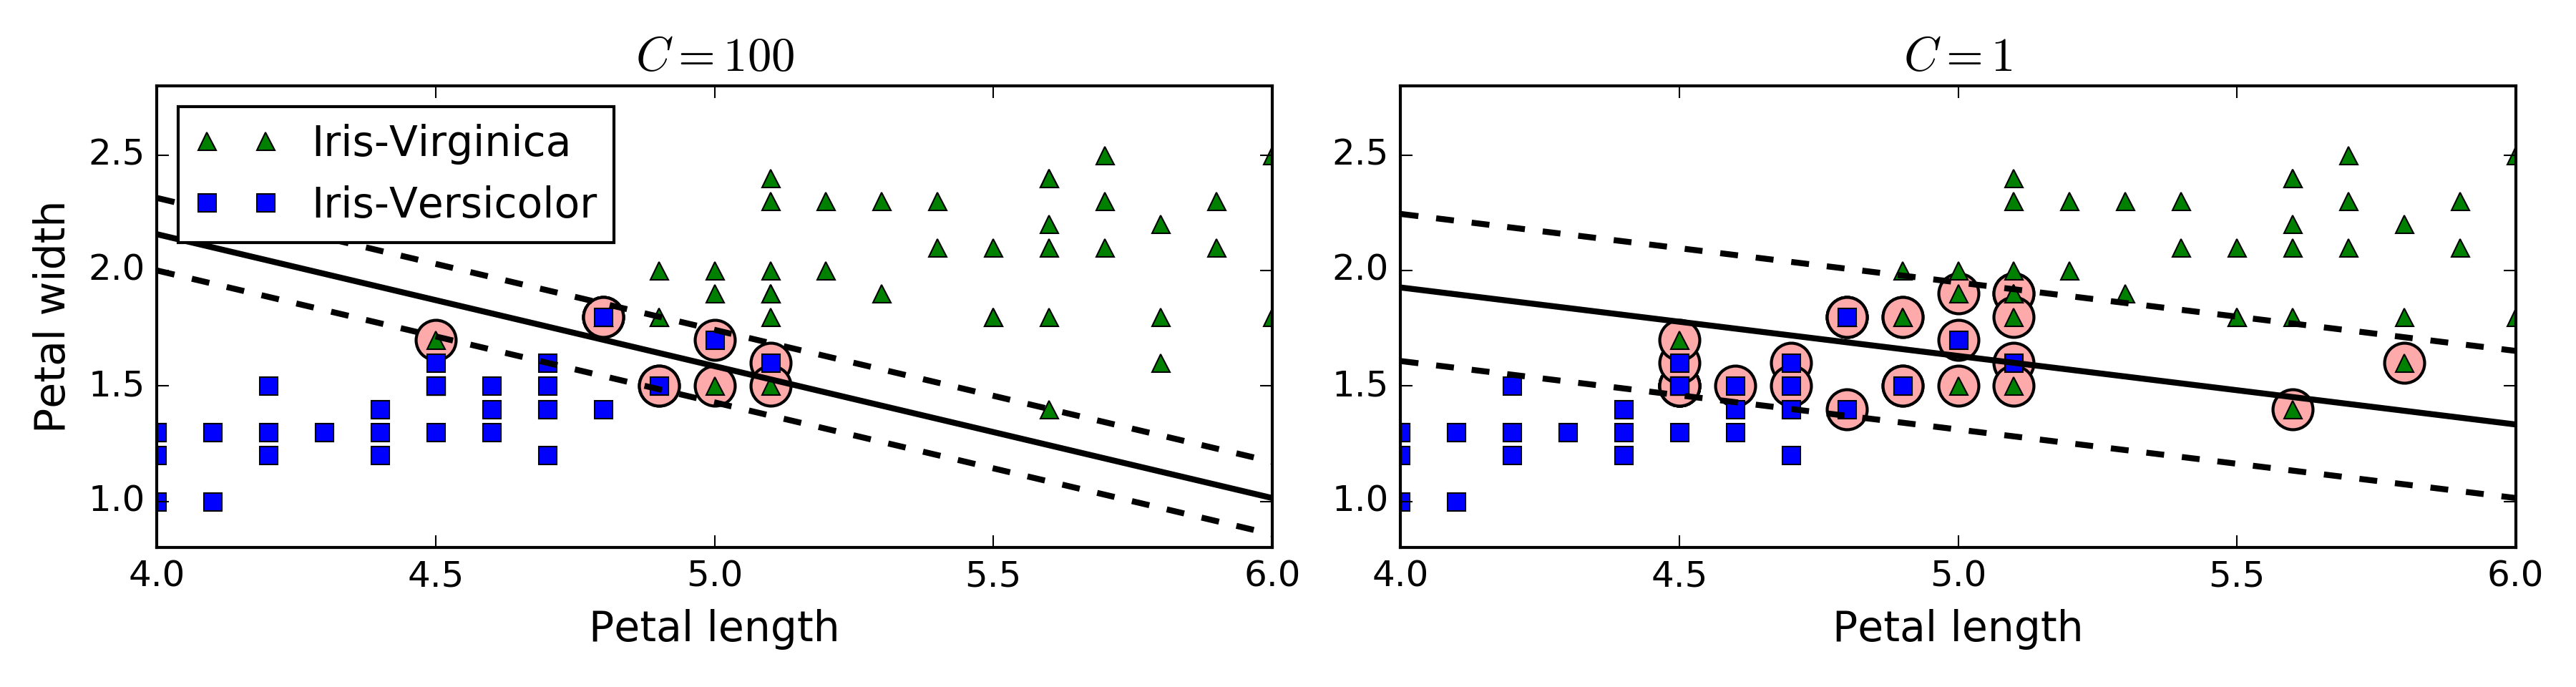

如果你的SVM模型过拟合，你可以尝试通过**减少C**来使其正则化

以下Scikit-Learn代码
* 加载鸢尾花数据集，
* 进行特征缩放，
* 然后训练**线性SVM模型**(使用C = 0.1的LinearSVC类和合页损失函数，后面马上会提到)

来检测Iris-Virginica花。结果模型显示在图5-4的右侧（即上图右侧）。

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris=datasets.load_iris()
X = iris["data"][:,(2,3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Viginica

svm_clf = Pipeline((
    ("scaler",StandardScaler()),
    ("linear_svc",LinearSVC(C=1,loss="hinge")),
))

svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

使用上面训练好的模型进行预测

In [5]:
svm_clf.predict([[5.5,1.7]])

array([1.])

下面的代码是生成比较不同正则化设置的图表：

In [6]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [7]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


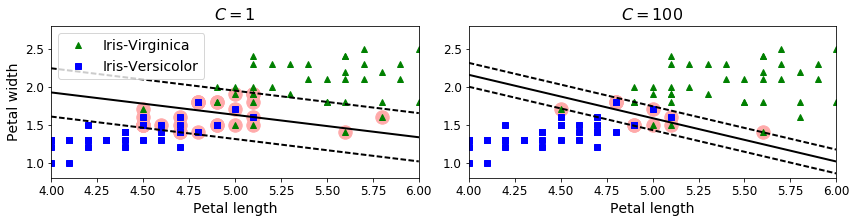

In [8]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

save_fig("regularization_plot")

**与Logistic回归分类器不同，SVM分类器不输出每个类的概率**。

- 你可以使用**SVC类**，使用**SVC（kernel =“linear”，C = 1）**，但速度要慢得多，特别是对于大型训练集，因此不推荐使用。

- 另一种选择是使用**SGDClassifier类**，使用**SGDClassifier（loss =“hinge”，alpha = 1 /（m * C））**。这适用于规则的随机梯度下降（见第4章）来训练线性SVM分类器。它不像LinearSVC类那样快速收敛，但它可以用于处理不适合内存（核外训练）的**大型数据集**，或处理**在线分类任务**。

**LinearSVC类**使偏差项正则化，因此应
* **首先通过减去其平均值来使训练集居中**。如果使用StandardScaler缩放数据，则会自动执行此操作。
* 此外，请确保将损失超参数设置为“hinge”，**因为它不是默认值**。
* 最后，为了获得更好的性能，您应该将双超参数设置为False，除非特征数比训练实例多（我们将在本章后面讨论二元性）。

## 5.2 Nonlinear SVM Classification

虽然线性SVM分类器是有效的，并且在许多方面工作得非常好，但是许多数据集甚至都**不能线性分离**。**处理非线性数据集的一种方法是添加更多特征**，例如**多项式特征**（如第4章所述）;在某些情况下，这可能会得到线性可分的数据集。

考虑图5-5中的左图：它表示只有一个特征$x_1$的简单数据集。可以看到，此数据集不是线性可分的。 但是，如果你添加一个**二次特征**$x_2 =(x_1)^2$，**得到的2D数据集完全可线性分离**。

Saving figure higher_dimensions_plot


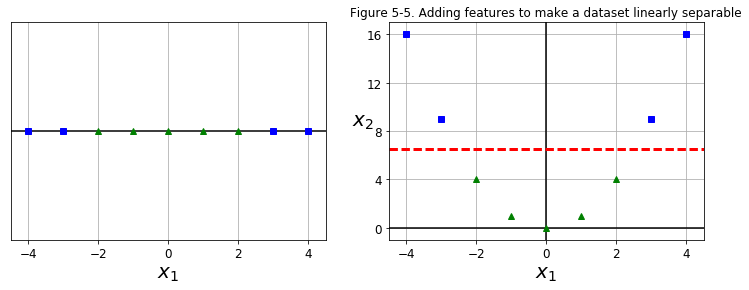

In [9]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))


plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])


plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)
plt.title('Figure 5-5. Adding features to make a dataset linearly separable')# not shown in the book
save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

要使用Scikit-Learn实现这个想法，你可以创建包含PolynomialFeatures变换器的管道（在第121页的“多项式回归”中讨论的），然后是StandardScaler和LinearSVC。 让我们在moons dataset 上测试一下（见图5-6）：

** 加载数据**

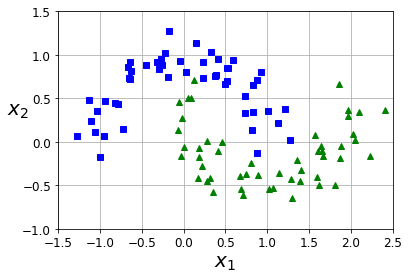

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [11]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf=Pipeline((("poly_features",PolynomialFeatures(degree=3)),
                            ("scaler",StandardScaler()),
                            ("svm_clf",LinearSVC(C=10,loss="hinge"))
                            ))

polynomial_svm_clf.fit(X,y)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

Saving figure moons_polynomial_svc_plot


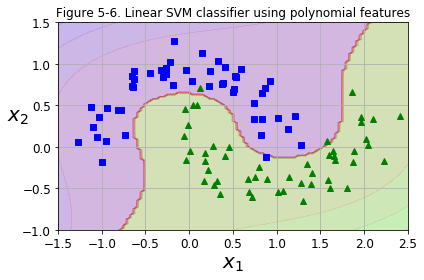

In [12]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title('Figure 5-6. Linear SVM classifier using polynomial features')# not shown in the book 

save_fig("moons_polynomial_svc_plot")
plt.show()

#### 5.2.1 Polynomial Kernel

添加多项式特征很容易实现，并且可以适用于各种类型的机器学习算法（不仅仅是SVM），但是
* 在低次多项式时它不能处理非常复杂的数据集，
- 在高次多项式下它会产生大量的特征，使得模型太慢。

幸运的是，当使用SVM时，你可以应用一种称为**核技巧**的几乎奇迹般的数学技术（稍后会对其进行解释）。**它可以获得与添加许多多项式特征相同的结果**，即使使用非常高的多项式，也无需实际添加它们。因此，由于您实际上没有添加任何特征，因此没有特征数量的组合爆炸。 这个技巧由SVC类实现。 让我们在moons dataset上测试它：

In [13]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

上面的代码使用 3 次多项式内核训练SVM分类器。它显示在图5-7的左侧。 右边是另一个使用 10 次多项式内核的SVM分类器。很显然，
* 如果模型过拟合，您可能希望降低多项式次数。
* 如果它欠拟合，你可以尝试增加它。

**超参数coef0** 控制模型受高次多项式与低次多项式的影响程度。

In [14]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])

poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Saving figure moons_kernelized_polynomial_svc_plot


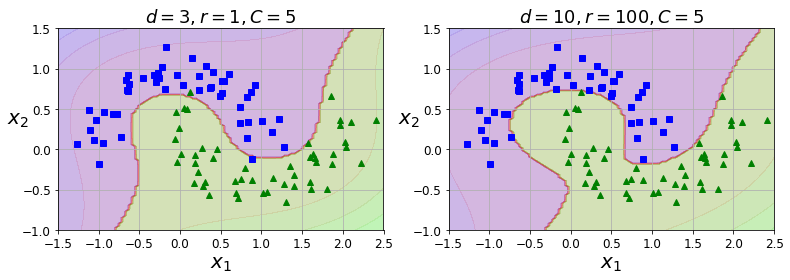

In [15]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)


save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

Figure 5-7. SVM classifiers with a polynomial kernel

找到正确的超参数值的常用方法是使用**网格搜索**（参见第2章）。 
* 首先进行**非常粗略的网格搜索**通常会更快，
* 然后围绕找到的最佳值进行**更精细的网格搜索**。 

充分了解每个超参数实际执行的操作也可以帮助您在超参数空间的正确部分进行搜索。

#### 5.2.2 Adding Similarity Features

解决非线性问题的另一种技术是**添加使用相似度函数计算的特征**，该函数测量每个实例与特定地标相似的程度。例如，
* 让我们采用前面讨论的一维数据集，并在 $x_1 = -2$ 和 $x_1 = 1$ 处为其添加两个地标（参见图5-8中的左图）。
* 接下来，让我们将相似度函数定义为 $γ= 0.3$ 的高斯径向基函数（RBF）（见公式5-1）。
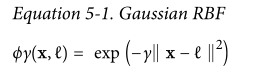


它是一个钟形函数，从0（距地标很远）到1（在地标处）不等。现在我们已准备好计算新特征。例如，让我们看一下实例**$x_1 = -1$** ：它位于距第一个地标距离为**1**的地方，距第二个地标距离为 **2**。因此，其新特征是 $x_2 = exp（-0.3×1^2）≈0.74$ 并且 $x_3 = exp（-0.3×2^2）≈0.30$。
图5-8右侧的图显示了转换后的数据集（删除原始特征）。如您所见，它现在可以线性分离了。

Saving figure kernel_method_plot


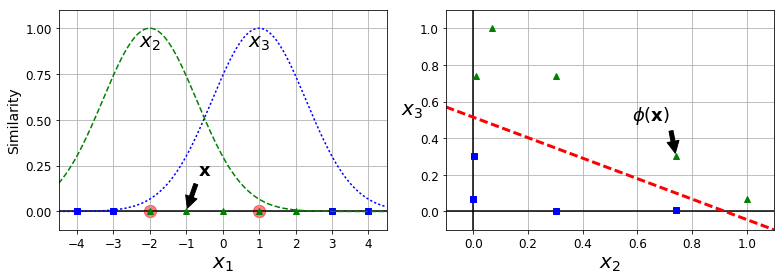

In [16]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [17]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


你可能想知道如何选择地标。最简单的方法是在数据集中每个实例的位置创建一个地标。这样创建了许多维度，从而增加了转换训练集可线性分离的机会。
**缺点是具有m个实例和n个特征的训练集被转换为具有m个实例和m个特征的训练集**（假设你删除了原始特征）。如果你的训练集非常大，那么你最终会获得相同数量的特征。

#### 5.2.3 Gaussian RBF Kernel

就像多项式特征方法一样，**相似特征方法可用于任何机器学习算法**，但计算所有附加特征可能计算成本很高，特别是在大型训练集上。然而，**核技巧再一次完成了它的SVM魔术**：它可以获得类似的结果，就像你添加了许多相似性特征一样，而不必实际添加它们。 让我们使用SVC类尝试**高斯RBF内核**：

In [18]:
rbf_kernel_svm_clf = Pipeline(( 
    ("scaler",StandardScaler()),
    ("svm_clf",SVC(kernel="rbf",gamma=5,C=0.001))
))

rbf_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

该模型显示在图5-9的左下角。其他图显示了使用不同的超参数值**gammaγ（γ）和 C** 训练的模型。
* 增加 gamma γ 使钟形曲线变窄（见图5-8的左图），因此每个实例的影响范围都较小：决策边界最终变得更不规则，在个别实例周围摆动。
* 减少 gamma γ 值使钟形曲线变宽，因此实例具有更大的影响范围，并且决策边界更加平滑。

所以**γ就像一个正则化超参数**：
* 如果你的模型过拟合，你应该减少它，
* 如果它是欠拟合，你应该增加它（类似于C超参数）。

Saving figure moons_rbf_svc_plot


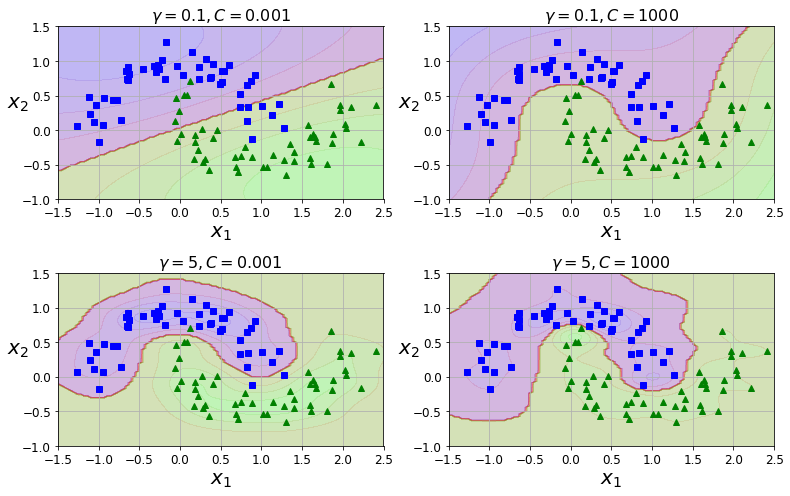

In [19]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

save_fig("moons_rbf_svc_plot")
plt.show()

除了我们上面提到的**多项式内核**和**高斯RBF内核**，还存在其他内核但很少使用。例如，某些内核专门用于特定的数据结构。
在分类文本文档或DNA序列时，有时会使用**字符串内核**（例如，使用**字符串子序列内核**或**基于Levenshtein距离的内核**）。

有这么多内核可供选择，你如何决定使用哪一个？根据经验，
* 你应该首先尝试**线性内核**（请记住，LinearSVC比SVC(内核=“线性”)快得多），特别是如果**训练集非常大**或者它**有很多特征**。 如果训练集不是太大，你应该试试**高斯RBF内核**也是如此; 它在大多数情况下效果很好。
* 然后，如果你有空闲时间和计算能力，您还可以使用**交叉验证和网格搜索**来尝试其他一些内核，**特别是如果有专门针对您的训练集的数据结构的内核**。

#### 5.2.4 Computational Complexity-计算复杂性

**LinearSVC类**基于liblinear库，它实现了优化线性SVM算法。
- 它不支持内核技巧，但它几乎与训练实例的数量和特征数量成线性关系：其训练时间复杂度大致为$O（m×n）$。

- 如果你需要非常高的精度，算法需要更长的时间。这由公差超参数$ε$（在Scikit-Learn中称为**tol**）控制。在大多数分类任务中，默认公差超参数表现就很好。

**SVC类**基于libsvm库，该库实现了支持内核技巧的算法。
- 训练时间复杂度通常在$ O（m_2×n）$和 $O（m_3×n）$之间。不幸的是，这意味着当训练实例的数量变大（例如，数十万个实例）时，它变得非常慢。

- 该算法适用于**复杂但小型或中型训练集**。但是，它随着特征的数量很好地扩展，特别是对于**稀疏特征**（即，当每个实例具有很多的零特征时）。在这种情况下，算法大致按每个实例的非零特征的平均数量进行缩放。

表5-1比较了Scikit-Learn的SVM分类类。
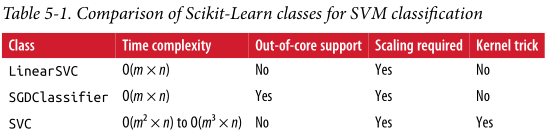

#### 5.2.a SVM Regression

正如我们前面提到的，SVM算法非常通用：**它不仅支持线性和非线性分类，还支持线性和非线性回归**。 诀窍是扭转目标：
* **SVM回归**试图在间隔中拟合尽可能多的实例，同时限制边际违规（即间隔外的实例），
* 而不是试图拟合两个类别之间最大可能的间隔，同时限制边际违规。间隔的宽度由超参数$ε$控制。 

图5-10显示了在一些随机线性数据上训练的两个线性SVM回归模型，一个具有较大的宽度$（ε= 1.5）$，另一个具有较小的宽度$（ε= 0.5）$。
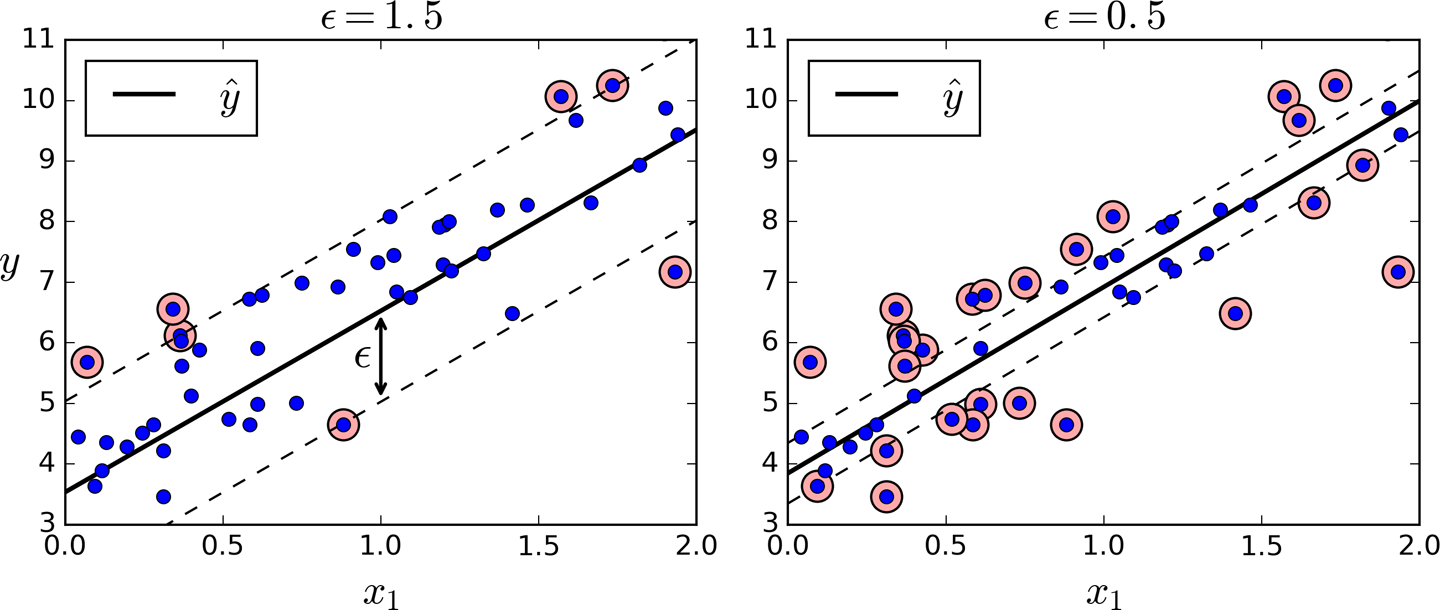

在间隔内添加更多训练实例不会影响模型预测; 因此，该模型被认为是$ε-不敏感( ϵ -insensitive.)$。

您可以使用Scikit-Learn的LinearSVR类来执行**线性SVM回归**。以下代码生成图5-10左侧所示的模型（训练数据应先缩放并居中）：

In [20]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [21]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

In [22]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Saving figure svm_regression_plot


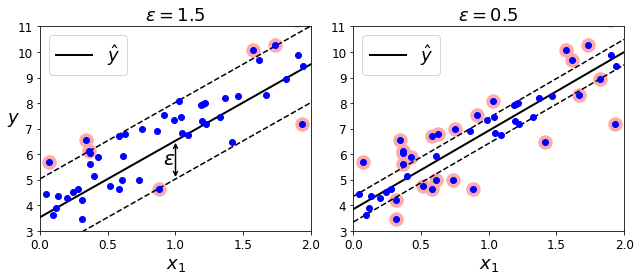

In [23]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

要处理**非线性回归任务**，可以使用**内核SVM模型**。例如，图5-11显示了SVM回归在随机二次训练集上使用 2 次多项式内核。 在左图上几乎没有正则化（即，大的**C**值），在右图上有更多的正则化（即，小的**C**值）。

以下代码使用**Scikit-Learn的SVR类**（支持内核技巧）生成图5-11左侧所示的模型。 
* SVR类与SVC类的回归等价
* LinearSVR类与LinearSVC类的回归等价。 

LinearSVR类与训练集的大小成线性比例（就像LinearSVC类一样），而当训练集变大时SVR类变得太慢（就像SVC类一样）。SVM也可用于**异常值检测**; 有关详细信息，请参阅Scikit-Learn的文档。

In [27]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [28]:
from sklearn.svm import SVR

svm_poly_reg =SVR(kernel="poly",degree=2,C=100,epsilon=0.1)
svm_poly_reg.fit(X,y)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


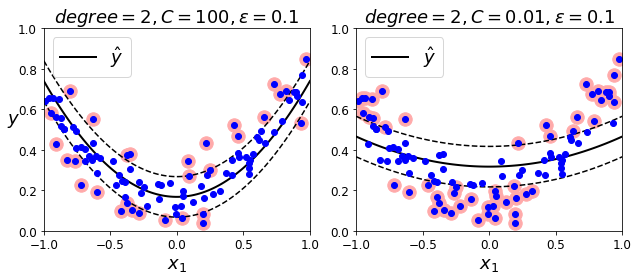

In [30]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

## 5.3 Under the Hood

本节从**线性SVM分类器**开始介绍SVM如何进行预测以及它们的训练算法是如何工作的。 如果您刚开始使用机器学习，可以安全地跳过它并直接进入本章末尾的练习，如果您想深入了解SVM，可以稍后再回来。

首先，关于符号：
* 在第4章中，我们使用了将所有模型参数放在一个向量 $θ$ 中的惯例，包括偏置项 $θ_0 $ 和输入特征权重 $θ_1$ 到 $ θ_n $，并向所有实例添加偏置输入 $ x_0 = 1 $。
* 在本章中，我们将使用不同的约定，在处理SVM时更方便（也更常见）：偏置项将被称为 $ b $，而特征权重向量将被称为 $w$。在输入特征向量中不会添加偏差特征。

### 概述

支持向量机致力于在正负样本的边界上找到一条**分割界线（超平面）**，使得它能完全区分两类样本的同时，保证划分出的间隔尽量的大。如果一条分割界线无法完全区分（线性不可分），要么加上**松弛变量**进行适当的容忍，要么通过**核函数**对样本进行空间上的映射后再进行划分。

#### 5.3.1 Decision Function and Predictions

线性SVM分类器模型通过简单地计算**决策函数** $ w^T·x + b = w_1 x_1 + ... + w_nx_n + b $ 来预测新实例 $x$ 的类：如果结果为正，则预测类 $ŷ$ 为正 类(1)，否则是负类(0); 见公式5-2。
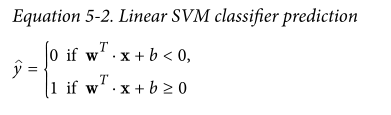

* 图5-12显示与图5-4右侧模型对应的决策函数：它是一个二维平面，因为该数据集有两个特征（花瓣宽度和花瓣长度）。 
* **决策边界**是决策函数等于0的点集：它是两个平面的交点，它是一条直线（由粗实线表示）。

In [31]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

Saving figure iris_3D_plot


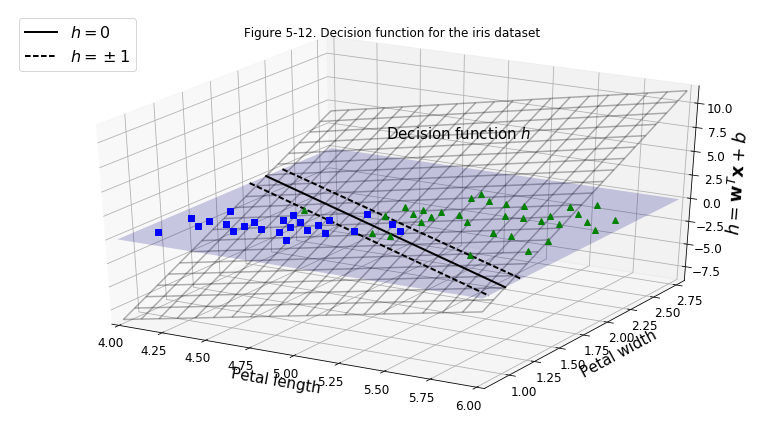

In [33]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])
plt.title('Figure 5-12. Decision function for the iris dataset')

save_fig("iris_3D_plot")
plt.show()

**虚线**表示决策函数**等于 1 或 -1 的点**：它们平行且与决策边界距离相等，形成一个**间隔**。**训练线性SVM分类器**意味着找到 **w** 和 **b** 的值，使这个**间隔尽可能宽**，同时避免边际违规（硬边界）或限制它们（软边距）

#### 5.3.2 Training Objective

考虑**决策函数的斜率**：它等于权重向量的范数，$∥w∥$。 **如果我们将该斜率除以2，则决策函数等于±1的点将远离决策边界两倍**。 换句话说，将斜率除以2将使边距乘以2.也许这在图5-13(即下面代码所绘制的图)中的2D图中更容易可视化。 **权重向量 w 越小，间隔越大**。

**A smaller weight vector results in a larger margin**

Saving figure small_w_large_margin_plot


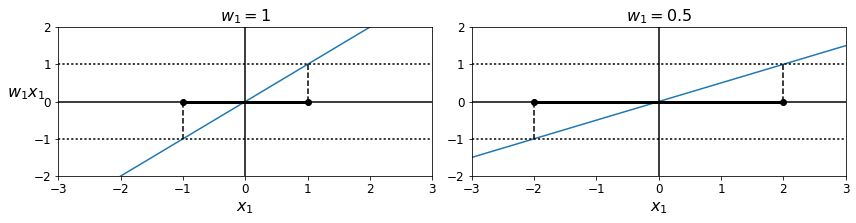

In [40]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))


plt.subplot(121)
plot_2D_decision_function(1, 0)

plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)


save_fig("small_w_large_margin_plot")
plt.show()

In [41]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

因此，我们**希望尽量减少$∥w∥$以获得较大的间隔**。但是，如果我们还想避免任何保证金违规（硬边际），那么
* 对于所有正面训练实例，我们需要决策函数**大于 1**
* 对于所有负面训练实例，我们需要决策函数**小于-1**

如果我们为负实例定义 $t^{(i)}= -1$(如果$ y^(i)= 0$)并且对于正实例定义$t^{(i)}= 1$（如果$ y^(i)= 1$），那么对于所有实例我们可以将这个约束表达为$t^{(i)}(w ^T·x^{(i)}+ b)≥1$。因此，我们可以将**硬间隔线性SVM分类器的目标**表达为公式5-3中的约束优化问题：
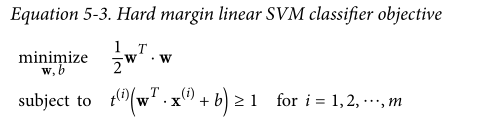

我们正在最小化$\frac{1}{2} w^T·w$，等价于 $\frac{1}{2}∥w∥^2$，而不是最小化$∥w∥$。这是因为它会给出相同的结果
（因为最小化一个值的 $w$ 和 $b$ 的值同时也最小化其平方的一半），但是$\frac{1}{2}∥w∥^2$有一个很好的简单的导数（它只是 $w$），而$∥w∥$在 $w = 0$ 时不可微分 优化算法在可微函数上运行得更好。

为了得软间隔分类的目标，我们需要为每个实例引入一个松弛变量$ζ^{(i)}≥ 0$：$ζ^{(i)}$ 测量允许第i个实例违反边界的程度。我们现在有两个相互矛盾的目标：
* 使松弛变量尽可能小以减少边际违规（误分类），并使$\frac{1}{2} w^T·w$尽可能小以增加间隔。
这就是超参数**C**的用武之地：它允许我们定义这两个目标之间的权衡。这给出了我们公式5-4中的约束优化问题
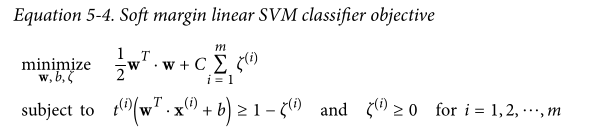

这里$C > 0$成为惩罚参数，一般由应用问题决定，
* C 值大时对误分类的惩罚增大，
* C 值小时对误分类的惩罚减小。

#### 5.3.3 Quadratic Programming

硬间隔和软间隔问题都是线性约束的凸二次优化问题。这些问题称为**二次规划（QP）问题**。许多现成的求解器可以使用本书范围之外的各种技术来解决QP问题。 一般问题公式由公式5-5给出:
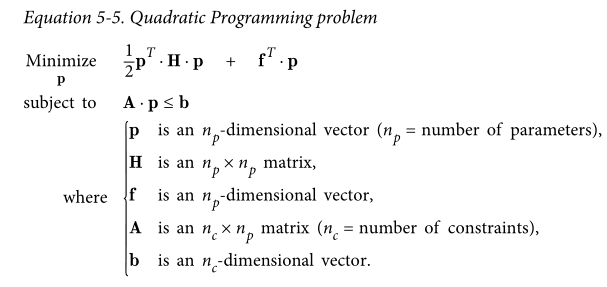

注意，表达式$ A·p ≤ b$实际上定义了$n_c$个约束：对于$i = 1,2，⋯，n_c$，$p^T·a^{(i)}≤b^{(i)}$，其中$a^{(i)}$是包含$A$第 $i$ 行元素的向量, $b（i） $是 $b $的第 $i$ 个元素。

您可以轻松验证如果以下列方式设置**QP**参数，得到硬间隔线性SVM分类器目标：
* $n_p = n+1$, n 是特征数量，**+1** 这一项是偏差项
* $n_c = m$，m 是训练实例的数量
* $H$ 是$n_p×n_p$是单位矩阵，除了在左上角的一项为零（忽略偏差项）。
* $f = 0$ ,一个$n_p$ 维的向量，元素都为0
* $b = 1$ ,一个$n_c$ 维的向量，元素都为1


因此，训练硬间隔线性SVM分类器的一种方法就是使用现成的QP求解器通过传递前面的参数。得到的向量$p$将包含偏置项$b = p_0$，并且对于$i = 1,2，...，m$，特征权重$w_i = p_i$。同样，您可以使用QP求解器来解决软间隔问题（参见本章末尾的练习）。

然而，为了使用核技巧，我们将研究一个不同的约束优化问题。

#### 5.3.4 The Dual Problem

给定一个约束优化问题，称为**原始问题**，有可能表达一个不同但密切相关的问题，称其为**对偶问题**。对偶问题的解决方案通常给出原始问题的解决方案的下限，但在某些条件下它甚至可以**具有与原始问题相同的解决方案**。幸运的是，SVM问题碰巧满足这些条件，因此您可以选择解决原始问题或对偶问题;两者都有相同的解决方案。 公式5-6显示了**线性SVM目标的对偶形式**（如果您有兴趣知道如何从原始问题中导出对偶问题，请参阅附录C）。
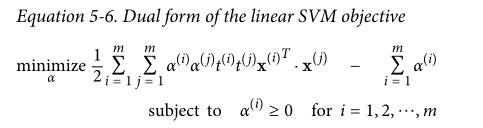

一旦找到最小化该等式的向量$ α_{hat} $（使用QP求解器），您就可以计算$w_{hat}$和$b_{hat}$通过使用公式5-7最小化原始问题:
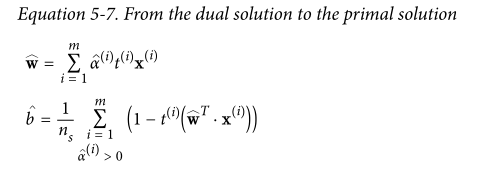

**当训练实例的数量小于特征的数量时，对偶问题比原始问题解决得更快。更重要的是，它使核技巧成为可能，而原始问题不可以。那么这个核技巧究竟是什么呢？**

#### 5.3.5 Kernelized SVM-核SVM

假设你要将二维多项式变换应用于二维训练集（例如moons train set ），然后在变换的训练集上训练线性SVM分类器。公式5-8显示了要应用的第二个多项式映射函数:
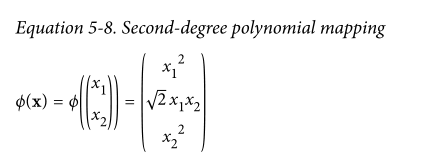

注意，变换后的矢量是三维的而不是二维的。现在让我们来看看**如果我们应用这个二次多项式映射，然后计算变换向量的点积（见公式5-9）**。几个二维向量a和b会发生什么，
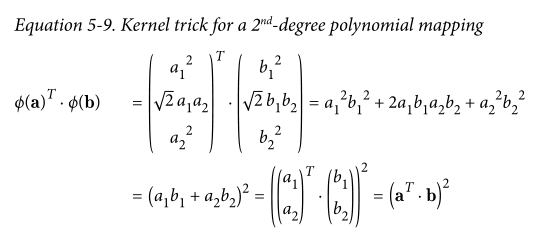

**变换矢量的点积等于原始矢量的点积的平方**：$φ(a)^T·φ(b)=(a^T·b)^2$。

这里是理解的关键：
* **如果将变换$φ$应用于所有训练实例，那么对偶问题（见公式5-6）将包含点积$φ(x^{(i)})^T·φ(x^{(j)})$。**
* **但如果$φ$是公式5-8中定义的第二个多项式变换，然后你可以简单地用$(x^{{(i)}^T}·x^{(j)})^2$取代转换矢量的这个点积**

所以你根本不需要转换训练实例：
* **只需用公式5-6中的平方替换点积。 结果将与您实际转换训练集然后拟合线性SVM算法的问题完全相同，但这个技巧使整个过程在计算上更有效率。 这是核技巧的本质**

函数$K(a，b) =(a^T·b)^2$被称为二次多项式内核。在机器学习中，**内核是能够仅基于原始矢量a和b计算点积$φ(a)^T·φ(b)$的函数**，而不必计算（或甚至知道）变换$φ$。 公式5-10列出了一些最常用的内核：
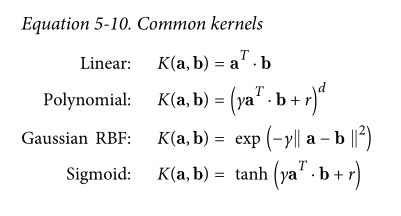

### Mercer’s Theorem-Mercer定理
根据Mercer定理，
* 如果函数$K（a，b）$满足一些称为Mercer条件的数学条件（K必须是连续的，其参数对称，因此$K（a，b）= K（b，a）$等），
* 然后存在将a和b映射到另一个空间（可能具有更高维度）的函数$φ$，使得$K（a，b）=φ（a）^T·φ（b）$。
那么你就可以使用**K**作为内核，因为你知道 $φ$ 存在，即使你不知道 $φ$ 是什么。在高斯RBF内核的情况下，可以看出，$φ$ 实际上将每个训练实例映射到一个无限维空间，所以你不需要实际执行映射是一件好事！**请注意，一些经常使用的内核（例如Sigmoid内核）不符合Mercer的所有条件，但它们通常在实践中运行良好**。

还有一点需要提一下。公式5-7显示了在**线性SVM分类器**的情况下如何从对偶问题转到原始问题，但如果应用核技巧，最终会得到包含$φ(x^{(i)})$的方程式。实际上，w_hat 必须具有与$φ(x^{(i)})$相同的维数，这可能是巨大的甚至是无限的，因此我们无法计算它。 但是你怎么能在不知道 w_hat 的情况下做出预测，好消息是你**可以将w_hat的公式从公式5-7插入到新实例$x(n)$的决策函数中，得到一个只有输入向量之间点积的方程式**。 这使得再次使用核技巧成为可能（公式5-11）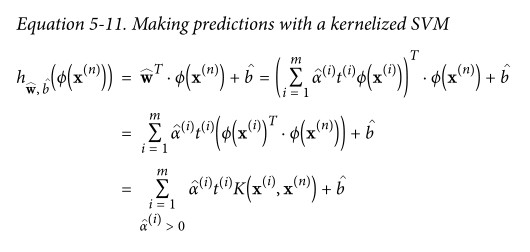

注意，因为$α(i)≠0$仅用于支持向量，涉及计算只有支持向量的新输入向量x(n)的点积，进而进行预测，而不是所有训练实例。 当然，您还需要使用相同的技巧计算偏差项b（公式5-12）。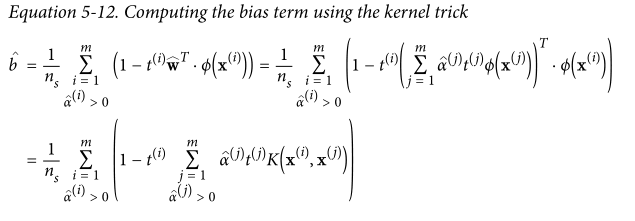

如果你开始觉得头晕，这是很正常的：这是内核技巧的不幸副作用。多参考各种资料，多理解，自己试着推导，慢慢就好了

#### 5.3.6 Online SVMs

在结束本章之前，让我们快速浏览一下**在线SVM分类器**（回想一下在线学习意味着逐步学习，通常是在新实例到来时）。

对于线性SVM分类器，一种方法是使用Gradient Descent（例如，使用SGDClassifier）最小化公式5-13中的成本函数，该公式是从原始问题导出的。 不幸的是，它比基于QP的方法收敛得慢得多。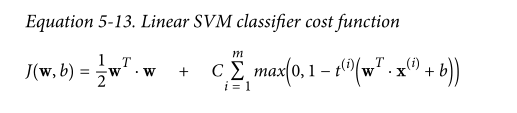

成本函数中的
* 第一个累加和将推动模型具有小的权重向量w，导致更大的间隔。
* 第二个计算所有误分类的总和。 

如果实例的边际违规位于间隔外且位于正确的一侧，则其等于0，否则它与到间隔正确边的距离成比例。最小化此术语可确保模型使边际违规尽可能小且极少

**本章的最后一个知识点是合页损失函数，请查看李航的统计学习方法第114页和115页**

Saving figure hinge_plot


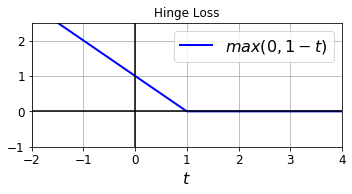

In [44]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
plt.title('Hinge Loss')

save_fig("hinge_plot")
plt.show()

## Extra material

### Training time

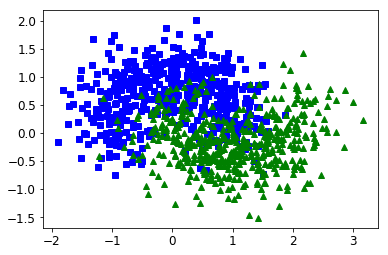

In [45]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.29720520973205566
[LibSVM]1 0.01 0.3022117614746094
[LibSVM]2 0.001 0.3535432815551758
[LibSVM]3 0.0001 0.6453745365142822
[LibSVM]4 1e-05 1.0493223667144775
[LibSVM]5 1.0000000000000002e-06 0.9674296379089355
[LibSVM]6 1.0000000000000002e-07 1.0645215511322021
[LibSVM]7 1.0000000000000002e-08 1.0575025081634521
[LibSVM]8 1.0000000000000003e-09 1.0467514991760254
[LibSVM]9 1.0000000000000003e-10 1.0387156009674072


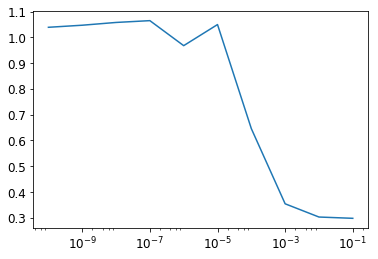

In [46]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times)

### Linear SVM classifier implementation using Batch Gradient Descent

In [47]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris-Virginica

In [48]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

[0, 60000, 0, 100]

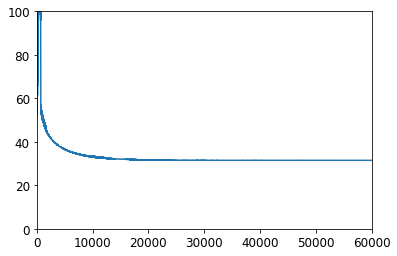

In [49]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [50]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [51]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


[4, 6, 0.8, 2.8]

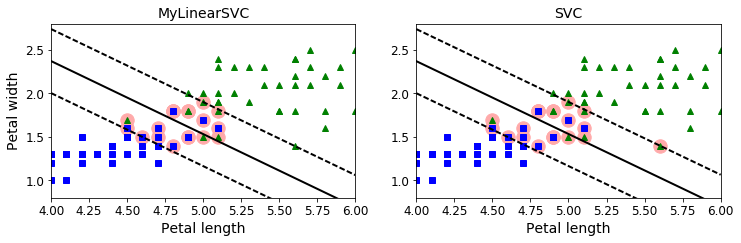

In [52]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

[-14.06195929   2.24179316   1.79750198]


[4, 6, 0.8, 2.8]

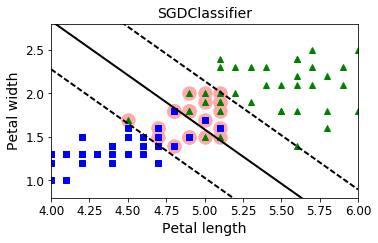

In [53]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, max_iter = 50, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

## Exercise solutions

#### 1. to 7.
See [Chapter - 5 Exercise(1-7)](https://www.jianshu.com/p/b336f87ad029).

#### 8. 
在线性可分的数据集上训练LinearSVC。然后在同一数据集上训练SVC和SGDClassifier。看看你是否可以让他们产生大致相同的模型。

我们使用Iris数据集：Iris Setosa和Iris Versicolor类是线性可分的。

In [54]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [55]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=100000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28474027] [[1.0536456  1.09903032]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.319] [[1.12072936 1.02666842]]


画出决策边界

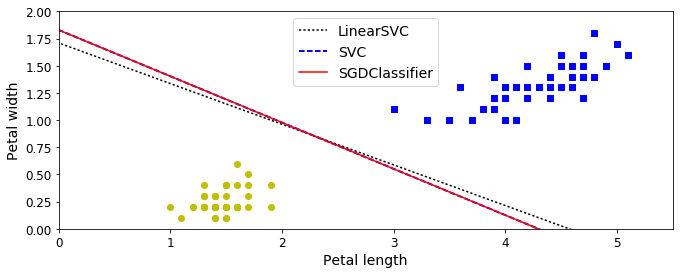

In [56]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

#### 9. 
在MNIST数据集上训练SVM分类器。由于SVM分类器是二元分类器，因此需要使用one-all来对所有10个数字进行分类。你可能希望**使用小型验证集调整超参数**以加快该过程。 

首先，让我们加载数据集并将其拆分为训练集和测试集。我们可以使用train_test_split（），但人们通常只需要训练集的前60,000个实例，以及测试集的最后10,000个实例（这样就可以将模型的性能与其他模型进行比较）：

In [57]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


许多训练算法对训练实例的顺序很敏感，因此通常最好先将它们打乱：

In [58]:
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

让我们从简单的**线性SVM分类器**开始。它将自动使用One-vs-All（也称为One-vs-the-Rest，OvR）策略，因此我们不需要做任何特别的事情。 这个很简单！

**9.1.1 训练线性SVM分类器**

In [59]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

让我们对训练集进行预测并测量准确度（我们还不想在测试集上测量它，因为我们还没有选择和训练最终模型）：

**9.1.2 使用训练好的线性SVM分类器进行预测**

In [60]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.85375

在MNIST 数据集上，85％的准确率是一个非常糟糕的表现。 这个线性模型对于MNIST来说当然太简单了，但也许我们只需要首先**扩展数据**：

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**9.2.1 扩展数据后，训练线性SVM分类器**

In [62]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

**9.2.2 扩展数据后，使用训练好的线性SVM分类器进行预测**

In [63]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9204

这次要好得多（我们将错误率降低了两倍），但对于MNIST来说仍然不是很好。 如果我们想使用SVM，我们将不得不使用内核。 让我们尝试一个**带有RBF内核的SVC**（默认）。

**警告**：如果您使用Scikit-Learn≤0.19，SVC类默认使用One-vs-One（OvO）策略，因此如果您想使用OvR策略，则必须明确设置decision_function_shape =“ovr”（(OvR是自0.19以来的默认值)。

**9.3.1 训练带有RBF内核的SVC**

In [64]:
svm_clf = SVC(decision_function_shape="ovr")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

**9.3.2 使用训练好的带有RBF内核的SVC进行预测**

In [65]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.94615

这很有希望，即使我们训练模型的数据少了6倍，我们也能获得更好的性能。 让我们通过**交叉验证**进行**随机搜索**来调整超参数。 我们将在一个小数据集上执行此操作，以加快该过程：

**9.4.1 使用交叉验证和随机搜索，对刚刚获得的带有RBF内核的SVC(即：svm_clf)进行超参数调整**

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.7s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.8s
[CV] C=8.852316058423087, gamma=0.001766074650481071 .................
[CV] .. C=8.852316058423087, gamma=0.001766074650481071, total=   0.7s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   0.9s
[CV] C=1.8271960104746645, gamma=0.006364737055453384 ................
[CV] . C=1.8271960104746645, gamma=0.006364737055453384, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .. C=9.875199193765326, gamma=0.051349833451870636, total=   1.0s
[CV] C=9.875199193765326, gamma=0.051349833451870636 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   44.6s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024A4CEB1978>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024A4CDDFBE0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

超参数调整后查看最好的超参数组合

In [67]:
rnd_search_cv.best_estimator_

SVC(C=8.852316058423087, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

查看分数

In [68]:
rnd_search_cv.best_score_

0.856

这看起来很低但请记住我们**只在1000个实例**上训练了模型。 让我们重新训练**整个训练集**中的最佳估计（在晚上运行，需要几个小时）：

由于我使用的是自己的笔记本电脑，所以下面三个cell就没有运行，各位看官可量力而行

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

**9.4.2 让我们选择具有最佳超参数的这个模型。 在测试集上测试它**：

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

不算太糟糕，但显然这个模型略微过拟合。 很容易调整超参数（例如降低C和/或伽玛），但是我们冒着过拟合测试集的风险。
其他人发现**超参数C = 5和γ= 0.005** 会产生更好的性能（精度超过98％）。通过将随机搜索运行更长时间并在训练集的更大部分上运行，您也可以找到它。

#### 10.

在加州住房数据集上训练SVM回归。

让我们使用Scikit-Learn的**fetch_california_housing（）**函数加载数据集：

In [69]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

划分训练集和测试集：

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**不要忘记缩放数据：**

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

让我们先训练一个简单的LinearSVR：

**10.1.1 训练LinearSVR**

In [72]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

**10.1.2 对训练好的LinearSVR模型在训练集上进行预测**

In [74]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9612806653297273

我们来看看RMSE：

In [75]:
np.sqrt(mse)

0.9804492160890983

在这个训练集中，标签的单位是万美元。**RMSE可以大致了解你应该预期的错误类型（对于大错误具有更高的权重）**：因此，对于此模型，我们可以预期误差大约在10,000美元左右。 不是很好。 让我们看看**使用RBF内核**我们是否可以做得更好。我们将使用**交叉验证**和**随机搜索**来找到适当的超参数值**C和gamma**：

**10.2.1**
* 使用RBF内核训练SVR
* 使用交叉验证和随机搜索来找到适当的超参数值C和gamma，即对带有RBF内核训练SVR进行超参数调整

In [76]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

C:\Users\baideqian\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.7s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.6s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   5.7s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.3s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.1s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   5.1s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.5s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   4.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.4min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024A4CC4BEB8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024A4CD09FD0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [77]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

现在让我们测量训练集上的RMSE：

In [78]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785357

看起来比线性模型好多了。 让我们**选择这个具有最佳超参数的模型并在测试集上进行评估**：

In [79]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528746

### 总结

#### SVM用于分类 - Classification问题时：
* 首先使用简单的线性SVM分类器
   * 如果需要扩展数据就扩展数据，再使用简单的线性SVM分类器
* 然后使用带有RBF内核的**SVC**
* 最后使用**交叉验证和随机搜索**，对带有RBF内核的SVC进行超参数调整
#### SVM用于回归 - Regression（预测）问题时：
* 首先使用简单的LinearSVR
* 然后使用带有RBF内核的**SVR**
* 最后使用**交叉验证和随机搜索**，对带有RBF内核的SVR进行超参数调整

注意在 sklearn 中**SVC**和**SVR**最后一个字母分别代表 Classification - 分类和Regression - 回归